### **Pontificia Universidad Javeriana**

##### **Curso de Procesamiento de Alto Volumen de Datos**


**Autor:** Juan Felipe González Quintero

**Fecha de inicio:** 28 -07 - 2025
**Fecha actual:** 06 - 10 - 2025

### **Trabajo en Cluster HPC**

## **Problemática**

Se tiene que el tratamiento del agua debe ser indispensable para garantizar la pureza y la calidad. Uno de los elementos significativos es aplicar los conceptos de los Procesamiento de Datos en Alto Volúmen para solucionar este tipo de problemas que afectan la salud pública. El presente ejemplo tiene como propósito tener en cuenta una metodología para aplicar el PAVD para solucionar o diagnósticar la calidad del agua en la India.

## **Objetivo**

Implementar modelos de predicción utilizando la biblioteca de aprendizaje automático MLib PySpark, con el fin de explorar y aplicar técnicas de IA en entornos de procesamiento con alto volúmen de datos.

## **Metodología**

1. Importación de los datos desde el Clúster de Procesamiento Spark construido previamente.

2. Preprocesamiento y limpieza de valores nulos, cambios de datos, EDA, medidas estadísticas, etc.

3. Entrenamiento de modelos: RL (MLlib), tensores (KERAS); la idea es predecir la calidad del agua en la INDIA.

4. Evaluación de los modelos: Se hará a través de diferentes medidas de rendimiento y visualizaciones comparativas entre modelos.

5. Se tiene como referencia el siguiente artículo sobre los parámetros de la calidad del agua: https://www.intechopen.com/chapters/69568



# **1.Importación y configuración de recursos**

In [1]:
import sys
print(sys.executable)


/home/estudiante/miniconda3/bin/python3


In [2]:
#Importación de todas las bibliotecas necesarias para procesamiento, gráficas y otros recursos
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Bibliotecas especializadas
from pylab import *

In [3]:
import os

# Ajuste de las variables de entorno
os.environ["PYSPARK_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"

print("Usando Python en:", os.environ["PYSPARK_PYTHON"])


Usando Python en: /home/estudiante/miniconda3/bin/python3


In [4]:
# Bibliotecas de Contexto PySpark, MLlib y contexto para levantar la sesión de PYSPARK

#Búsqueda de inicialización para pyspark
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F # Acceso a todas las funciones

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
#Se crea una sesión para hacer el contexto de procesamiento desde mi Cuota de cluster HPC (No tenemos acceso a todos los cores, son compartidos)
from pyspark import SparkConf
##Se levanta la configuración de mi Cuota
configura = SparkConf().set("spark.scheduler.mode", "FAIR")

configura.setAppName("HPC_Gonzalez")

spark06 = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext = spark06.sparkContext, sparkSession = spark06)

contextoSpark06 = spark06.sparkContext.getOrCreate()

print("Sesión cluster HPC: Gonzalez WaterQuality")

spark06

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/25 16:22:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sesión cluster HPC: Gonzalez WaterQuality


In [6]:
# Como estoy desde un servidor que no es mío y ni siquiera lo he implementado
# Requiero saber que configuración de hardware le han dado a mi cuota de sesión
# Adicional, requiero como hacer un cluster para saber la forma en la que se implementa

cantCPUS = spark06._jsc.sc().getExecutorMemoryStatus().keySet().size()
print(f"Cantidad de CPUS en mi cuota de sesión spark06: {cantCPUS} ")
print(spark06.sparkContext.getConf().getAll())

Cantidad de CPUS en mi cuota de sesión spark06: 1 
[('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.driver.host', 'NPDG16'), ('spark.scheduler.mod

In [7]:
print("Driver Python:", os.environ.get("PYSPARK_DRIVER_PYTHON"))
print("Worker Python:", os.environ.get("PYSPARK_PYTHON"))


Driver Python: /home/estudiante/miniconda3/bin/python3
Worker Python: /home/estudiante/miniconda3/bin/python3


# **2. Carga de datos desde el clúster**

In [8]:
#Especificamos la ruta donde está ubicado el archivo csv en el cuál vamos a basarnos para su procesamiento y análsis.
ruta = "/almacen/calidadAgua/waterquality.csv"

#Cargamos el archivo en forma de un dataframe con PySpark y mostramos los primeros 5 registros para verificar la carga correcta del archivo.
df00 = spark06.read.csv(ruta, header=True, inferSchema=True)
df00.show(5)


+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|8.0|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

# **3. Análisis y Preparación de Datos**

Se presentan datos (csv) con los diferentes parámetros de los ríos de la India. Cada parámetro es el promedio de los valores medidos en un período de tiempo. Los datos han sido extraídos de la web oficial de la India (RiverIndia)

- **Tipo de datos:** coherencia de tipo de datos, transformación, etc.
- **Columnas:** conocimiento de columnas, eliminación.
- **Análisis de datos nulos o imposibles:** conocimiento.


In [9]:
# Conocimiento de las columnas
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'TOTAL_COLIFORM']

Las columnas que se presentan son las siguientes:

- **'STATION CODE'**: Código de estación de medida
- **'LOCATIONS':** ubicación de los ríos
- **'STATE':** Estado de la India
- **'TEMP':** Temperatura del agua en °C
- **'DO':** Oxigeno disuelto (mg/L). Concentraciones altas de oxigeno representan mejor calidad de agua
- **'pH':** Logaritmo negativo de la concentración de hidrógeno
- **'CONDUCTIVITY':** Mide la habilidad de una conducir corriente. El agua pura no es conductora de corriente.
- **'BOD':** Bacterias y otros microorganismos que utilizan sustancias orgánicas como alimento. Demanda Bioquímica de oxígeno. Mayor cantidad de material orgánico indica amyor BDO.
- '**NITRATE_N_NITRITE_N':** Nitratos/Nitritos "nitrógeno". Altas concentraciones de nitrógeno en la superficie de agua pueden estimular el rápido crecimiento de algas las cuales degradan la calidad del agua (mg/L).
- **'FECAL_COLIFORM':** Promedio de bacteria coliformes: excresiones.
- '**TOTAL_COLIFORM':** Se eliminará pues no aporta al estudio de predicción de la calidad del agua.

Se presentan las estadísiticas de los datos a continuación

In [10]:
#Se hace una descripción estadísitca de los parámetros/variables del conjunto de datos para una exploración inicial
for valor in df00.columns:
  df00.describe([valor]).show()


+-------+-----------------+
|summary|     STATION CODE|
+-------+-----------------+
|  count|              534|
|   mean|2052.516853932584|
| stddev|755.2178560086894|
|    min|               11|
|    max|             3330|
+-------+-----------------+

+-------+-------------------+
|summary|          LOCATIONS|
+-------+-------------------+
|  count|                534|
|   mean|               NULL|
| stddev|               NULL|
|    min|          AHMEDABAD|
|    max|ZUARI AT PANCHAWADI|
+-------+-------------------+

+-------+--------------+
|summary|         STATE|
+-------+--------------+
|  count|           534|
|   mean|          NULL|
| stddev|          NULL|
|    min|ANDHRA PRADESH|
|    max|   WEST BENGAL|
+-------+--------------+

+-------+------------------+
|summary|              TEMP|
+-------+------------------+
|  count|               534|
|   mean|25.241398865784515|
| stddev|3.4480130875026624|
|    min|              10.5|
|    max|                NA|
+-------+---------

## **Exploración de valores nulos en los datos**

En esta sección usamos diferentes consultas para **revisar si en el conjunto de datos existen datos nulos o con valores imposibles** para poder realizar su limpieza, ya de no realizarse, podría verse afectada la generación de visualizaciones gráficas y las conclusiones a sacar de este estudio.

In [11]:
#Rastreamos la cantidad de valores nulos o imposibles
df00.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+



Al ejecutar esta consulta podemos concluir que **no** hay valores nulos o imposibles, por lo que se procede a graficar cada una de las dimensiones



In [12]:
#Se crea una vista para ser usada en las visualizaciones
df00.createOrReplaceTempView("df00_sql")

In [13]:
df01 = spark06.sql( ''' Select * from df00_sql where TEMP is not null and
                  DO is not null and
                  pH is not null and
                  CONDUCTIVITY is not null and
                  BOD is not null and
                  NITRATE_N_NITRITE_N is not null and
                  FECAL_COLIFORM is not null ''' )

In [14]:
#Se verifica la Cantidad de Valores Nulos o Imposibles
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+



## **Tratamiento de datos**

En esta sección **verificamos los tipos de datos asignados a cada una de las variables en el conjunto de datos**, esto con el fin de realizar los ajustes necesarios sin perder el sentido conceptual de las variables que serán usadas a lo largo del estudio.
    

In [15]:
#El método dtypes nos permite conocer los tipos de datos de las variables de nuestro dataframe
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'double'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

Como se puede evidenciar en la celda anterior, **una gran parte de las variables no corresponden con su tipo de datos** por lo que procedemos a realizar los ajustes pertinentes para darle sentido a estas variables. Estos cambios también nos permitirán graficar estas variables y clasificarlas en rangos en pro de realizar una mejor aproximación a la calidad del agua en términos estadísticos.

In [16]:
#Se procede a cambiar los tipos de datos
df00 = df00.withColumn('TEMP', df00['TEMP'].cast(FloatType()))
df00 = df00.withColumn('pH', df00['pH'].cast(FloatType()))
df00 = df00.withColumn('DO', df00['DO'].cast(FloatType()))
df00 = df00.withColumn('CONDUCTIVITY', df00['CONDUCTIVITY'].cast(FloatType()))
df00 = df00.withColumn('NITRATE_N_NITRITE_N', df00['NITRATE_N_NITRITE_N'].cast(FloatType()))
df00 = df00.withColumn('FECAL_COLIFORM', df00['FECAL_COLIFORM'].cast(FloatType()))
df00 = df00.withColumn('BOD', df00['BOD'].cast(FloatType()))

#Una vez realizamos los cambios, se imprimen nuevamente los tipos de datos para verificar si se efectuaron
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'string')]

Ya que la columna TOTAL_COLIFORM será eliminada (debido a que no aporta nada significativo al estudio), no es necesario aplicarle ninguna transformación, por lo que ahora procedemos a borrarla.

In [17]:
#Se elimina la columna TOTAL_COLIFORM
df01 = df00.drop('TOTAL_COLIFORM')
#Volvemos a imprimir las variables y los tipos de dato que les corresponden para verificar que se hayan aplicado todos los cambios. 
df01.columns
df01.dtypes


[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float')]

## **Creación de tablas para visualizar los datos**

 En esta sección se hace uso de la función LAMBDA para hacer tratamiento/limpieza de datos.


In [18]:
df01.createOrReplaceTempView("df01_sql")

#Se hace una consulta por cada parámetro
do_parametro = spark06.sql("Select DO from df01_sql")

#Se hace una consulta para crear el vector de la tabla por cada parámetro
do_parametro = do_parametro.rdd.map(lambda fila: fila.DO).collect()

#Se crea una consulta para el parámetro pH
ph_parametro = spark06.sql("Select pH from df01_sql")
ph_parametro = ph_parametro.rdd.map(lambda fila: fila.pH).collect()

#Se crea una consulta para el parámetro COND
cond_parametro = spark06.sql("Select CONDUCTIVITY from df01_sql")
cond_parametro = cond_parametro.rdd.map(lambda fila: fila.CONDUCTIVITY).collect()

#Se crea otra consulta para cada parámetro BOD
bod_parametro = spark06.sql("Select BOD from df01_sql")
bod_parametro = bod_parametro.rdd.map(lambda fila: fila.BOD).collect()

#Se crea otra consulta para cada parámetro NN
nn_parametro = spark06.sql("Select NITRATE_N_NITRITE_N from df01_sql")
nn_parametro = nn_parametro.rdd.map(lambda fila: fila.NITRATE_N_NITRITE_N).collect()

#Se crea otra consulra para cada parámetro FC
fc_parametro = spark06.sql("Select FECAL_COLIFORM from df01_sql")
fc_parametro = fc_parametro.rdd.map(lambda fila: fila.FECAL_COLIFORM).collect()

## **Visualizaciones gráficas de los datos**

En esta sección se realizan **visuales gráficas de algunos de los parámetros para medir la calidad del agua**, esto con el fin de comprender mejor cuál es el estado de la misma según los indicadores más importantes que se encuentran en el conjunto de datos.

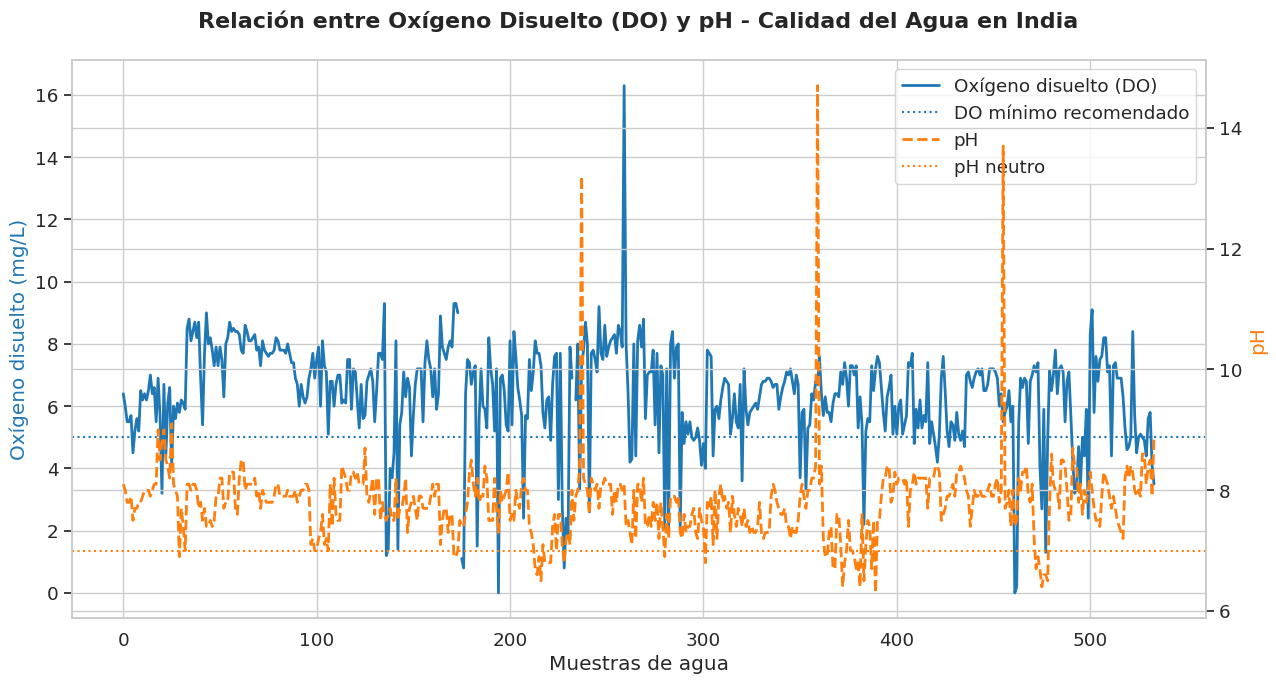

In [19]:
#Graficamos los parámetros para conocer sus estadísticas

# Configuración de estilo más profesional
sns.set(style="whitegrid", font_scale=1.2)

tam = len(do_parametro)
x = np.arange(tam)

fig, ax1 = plt.subplots(figsize=(13, 7))

# Color asignado manualmente para mayor contraste
color_do = sns.color_palette("tab10")[0]
color_ph = sns.color_palette("tab10")[1]

# Graficar Oxígeno Disuelto
ax1.plot(x, do_parametro, color=color_do, label='Oxígeno disuelto (DO)', linewidth=2)

# Eje secundario para el pH (ya que tienen escalas distintas)
ax2 = ax1.twinx()
ax2.plot(x, ph_parametro, color=color_ph, label='pH', linewidth=2, linestyle='--')

# Títulos y etiquetas
fig.suptitle('Relación entre Oxígeno Disuelto (DO) y pH - Calidad del Agua en India', fontsize=16, fontweight='bold')
ax1.set_xlabel('Muestras de agua')
ax1.set_ylabel('Oxígeno disuelto (mg/L)', color=color_do)
ax2.set_ylabel('pH', color=color_ph)

# Líneas de referencia para valores ideales
ax1.axhline(5, color=color_do, linestyle=':', linewidth=1.5, label='DO mínimo recomendado')
ax2.axhline(7, color=color_ph, linestyle=':', linewidth=1.5, label='pH neutro')

# Combinar leyendas de ambos ejes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()

### **Relación entre Oxígeno disuelto y el pH de los cuerpos de agua**
En esta gráfica se encuentran visualmente representadas dos de las variables que miden la calidad de los cuerpos de agua.

La primera de ellas es el **Oxígeno Disuelto**, la cuál en comparación al umbral mínimo, presenta una **variabilidad importante.** Aunque una buena parte de los cuerpos acuáticos cuenta con una buena oxigenación (es decir, valores por encima del umbral mínimo de 5mg/L), también se encuentran varias recaídas importantes que representan a los cuerpos acuáticos con baja oxigenación. Esto último puede deberse a contaminación orgánica, estancamiento o baja renovación del cuerpo o presencia de algas marinas y otras plantas acuáticas en descomposición.

En cuanto al **pH**, se muestra en los cuerpos de agua incluídos en el conjunto de datos una **tendencia general hacia pH ácido** en respuesta posiblemente a factores químicos del entorno como bien pueden ser vertimientos industriales o agrícolas teniendo en cuenta las actividades en las que la economía del páis está fuertemente involucrada como la industria textil.

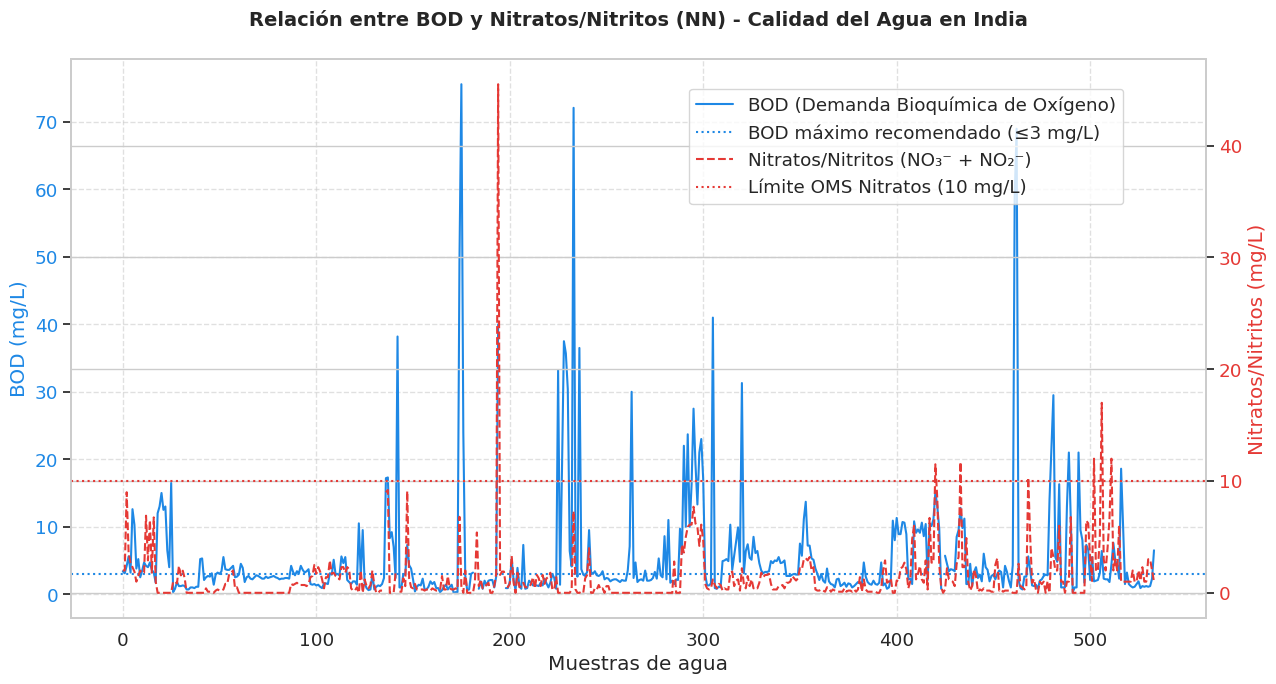

In [20]:
#Graficamos ls parámetros para conocer sus estadísticas

tam = len(bod_parametro)

fig, ax1 = plt.subplots(figsize=(13,7), facecolor='w', edgecolor='k')

# ----- Primer eje: BOD -----
ax1.plot(range(tam), bod_parametro, color='#1E88E5', label='BOD (Demanda Bioquímica de Oxígeno)')
ax1.axhline(3, color='#1E88E5', linestyle=':', label='BOD máximo recomendado (≤3 mg/L)')
ax1.set_xlabel('Muestras de agua')
ax1.set_ylabel('BOD (mg/L)', color='#1E88E5')
ax1.tick_params(axis='y', labelcolor='#1E88E5')
ax1.grid(True, which='major', linestyle='--', alpha=0.6)

# ----- Segundo eje: Nitratos/Nitritos -----
ax2 = ax1.twinx()
ax2.plot(range(tam), nn_parametro, color='#E53935', linestyle='--', label='Nitratos/Nitritos (NO₃⁻ + NO₂⁻)')
ax2.axhline(10, color='#E53935', linestyle=':', label='Límite OMS Nitratos (10 mg/L)')
ax2.set_ylabel('Nitratos/Nitritos (mg/L)', color='#E53935')
ax2.tick_params(axis='y', labelcolor='#E53935')

# ----- Título y leyenda -----
fig.suptitle('Relación entre BOD y Nitratos/Nitritos (NN) - Calidad del Agua en India',
             fontsize=14, fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.88))

plt.tight_layout()
plt.show()

### **Relación entre Demanda Bioquímica de Oxígeno (BOD) y el Nitritos/Nitratos presentes en los cuerpos de agua**
En esta gráfica se encuentran visualmente representadas dos de las variables que miden la calidad de los cuerpos de agua.

Por un lado se tiene el **BOD**, que mide la cantidad de oxígeno que requieren los microorganismos para descomponer materia orgánica en el agua. Para este caso, en color azul se observa la estadística del parámetro, llegando a tener **varios picos ampliamente superiores al BOD recomendado (3mg/L)**. Esto indica una alta carga orgánica, lo que a su vez implica grandes niveles de contaminación provenientes de vertimentos agrícolas o industriales principalmente, cosa que coincide con lo visto en la gráfica anterior a esta (DO y pH).

Luego, tenemos también en esta gráfica el nivel de **Nitritos y Nitratos** representado en color rojo, donde, al igual que con el BOD, se observan **concentraciones elevadas en distintos puntos**, con valores que superan el límite recomendado. Este patrón sugiere una posible contaminación por actividad agrícola, fertilizantes o aguas residuales no tratadas.

Estos parámetros se relacionan en el sentido en que, **donde se observan picos de BOD, también los encontramos en el nivel de NN**, ambos incrementos provocados por el **exceso de materia orgánica y nutrientes que estimula el crecimiento de algas, reduciendo el oxígeno disponible en el agua**.

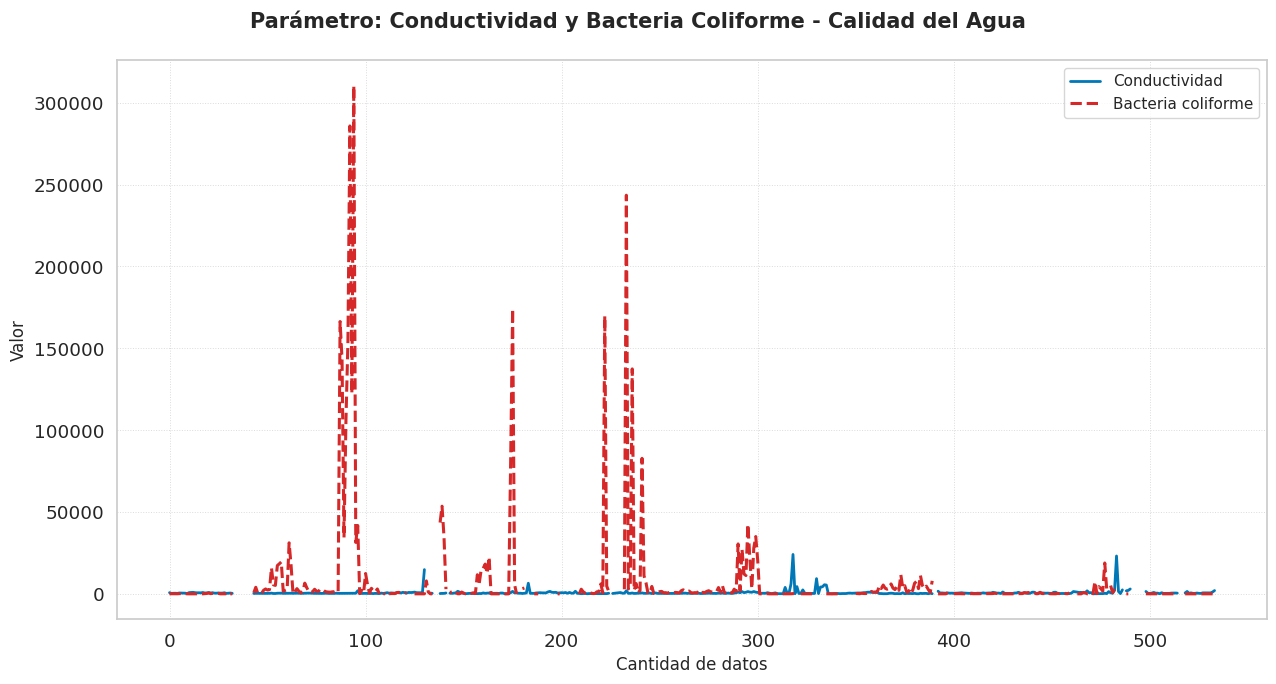

In [21]:
#Graficamos ls parámetros para conocer sus estadísticas

tam = len(do_parametro)

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(13, 7), facecolor='w', edgecolor='k')

# Graficar las variables con nuevos colores y estilos
ax1.plot(range(tam), cond_parametro, color='#0077b6', linestyle='-', linewidth=2, label='Conductividad')  # azul profundo
ax1.plot(range(tam), fc_parametro, color='#d62828', linestyle='--', linewidth=2.2, label='Bacteria coliforme')  # rojo coral

# Títulos y etiquetas
fig.suptitle('Parámetro: Conductividad y Bacteria Coliforme - Calidad del Agua', fontsize=15, fontweight='bold')
ax1.set_xlabel('Cantidad de datos', fontsize=12)
ax1.set_ylabel('Valor', fontsize=12)

# Mejoras visuales
ax1.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7)
ax1.legend(frameon=True, fontsize=11)
plt.tight_layout()

plt.show()


### **Relación entre Conductividad y Bacteria Coliforme presentes en los cuerpos de agua**
En esta gráfica se encuentran visualmente representadas dos de las variables que miden la calidad de los cuerpos de agua.

En primera instancia tenemos la **Conductividad** representada en color azul. En general se mantiene una **tendencia baja**, lo cuál indica que la contaminación del agua ya vista en gráficos anteriores no se asocia necesariamente a una gran concentración de sales o iones disueltos que están presentes en diferentes compuestos químicos.

Por otro lado, el gráfico de **bacteria coliforme** representado en color rojo, **muestra valores extremadamente altos** en varios tramos. Este patrón sugiere que ciertos cuerpos de agua no tienen contaminación constante, sino eventos puntuales de alta carga orgánica o fecal, posiblemente asociados a descargas domésticas o ade origen agrícola. 

Como tal **no se observa una correlación directa entre los dos parámetros, posiblemente debido a la diferencia de su naturaleza**, siendo que la conductividad en el agua proviene de la concentración de ciertos minerales que se desprenden de algunos componentes químicos, mientras que la bacteria coliforme viene de materia de origen natural.

## **Definición de rangos para la Calidad de agua**
En esta sección **se asocian los valores de los diferentes parámetros a ciertos rangos numéricos** para determinar de forma más sencilla la calidad de un cuerpo de agua

In [22]:
#Se requiere hacer una función definida por el usuario que permir definir la el rango de la calidad del agua según el pH
#Se crea la columna para los rangos del parámatero

df02 = df01.withColumn("qrPH", F.when((df01.pH>=7) & (df01.pH<=8.5), 100).
                       when(((df01.pH>=6.8) & (df01.pH<=6.9)) | ((df01.pH>8.5) & (df01.pH<8.6)), 80).
                       when(((df01.pH>=6.7) & (df01.pH<=6.8)) | ((df01.pH>=8.6) & (df01.pH<=8.8)), 60).
                       when(((df01.pH>=6.5) & (df01.pH<=6.7)) | ((df01.pH>=8.8) & (df01.pH<9)), 40).otherwise(0))

In [23]:
# Función definida por el usuario para definir el rango de la calidad del agua según DO
df02 = df02.withColumn("qrDO", F.when((df02.DO>=6), 100).
                       when((df02.DO>=5.1) & (df02.DO<6.0), 80).
                       when((df02.DO>=4.1) & (df02.DO<5.0), 60).
                       when((df02.DO>=3.0) & (df02.DO<=4.0), 40).otherwise(0))

In [24]:
### Función definida por el usuario para definir el rando de la calidad del agua según Conductividad
df02 = df02.withColumn("qrCOND", F.when(((df01.CONDUCTIVITY>=0.0) & (df01.CONDUCTIVITY<=75.0)), 100).
                                when((df01.CONDUCTIVITY>=75.0) & (df01.CONDUCTIVITY<150.0), 80).
                                when((df01.CONDUCTIVITY>=150.0) & (df01.CONDUCTIVITY<225.0), 60).
                                when((df01.CONDUCTIVITY>=225.0) & (df01.CONDUCTIVITY<300.0), 40).otherwise(0))

In [25]:
### Función definida por el usuario para definir el rando de la calidad del agua según BOD
df02 = df02.withColumn("qrBOD", F.when(((df01.BOD>=0.0) & (df01.BOD<=3.0)), 100).
                                when((df01.BOD>=8.0) & (df01.BOD<6.0), 80).
                                when((df01.BOD>=6.0) & (df01.BOD<80.0), 60).
                                when((df01.BOD>=80.0) & (df01.BOD<125.0), 40).otherwise(0))

In [26]:
### Función definida por el usuario para definir el rango de la calidad del agua según NN
df02 = df02.withColumn("qrNN", F.when(((df02.NITRATE_N_NITRITE_N>=0.0) & (df01.NITRATE_N_NITRITE_N<=20.0)), 100).
                       when((df02.NITRATE_N_NITRITE_N>20.0) & (df02.NITRATE_N_NITRITE_N<50.0), 80).
                       when((df02.NITRATE_N_NITRITE_N>50.0) & (df02.NITRATE_N_NITRITE_N<100.0), 60).
                       when((df02.NITRATE_N_NITRITE_N>100.0) & (df02.NITRATE_N_NITRITE_N<200.0), 40).otherwise(0))

In [27]:
df02 = df02.withColumn("qrFecal", F.when(((df01.FECAL_COLIFORM>=0.0) & (df01.FECAL_COLIFORM<=5.0)), 100).
                                when((df01.FECAL_COLIFORM>=5.0) & (df01.FECAL_COLIFORM<50.0), 80).
                                when((df01.FECAL_COLIFORM>=50.0) & (df01.FECAL_COLIFORM<500.0), 60).
                                when((df01.FECAL_COLIFORM>=500.0) & (df01.FECAL_COLIFORM<1000.0), 40).otherwise(0))

El objeto df02 contiene hasta ahora todos los calculos y registros sobre los rangos de calidad de agua

In [28]:
#A continuación se hace una inspección general del objeto df02
df02.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|    0| 100|    100|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|    0| 100|     60|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|                9.0|          59.0| 100|  80|     0|    0| 100|     60|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|       371.0| 5.6|               3.55|  

## **Creación de columas que contengan el indice de calidad de agua según la referencia bibliográfica**

In [29]:
#Se crea un nuevo dataframe con las nuevas columnas de Indice de Calidad
df03 = df02.withColumn("wpH", F.round(df02.qrPH*0.165,3))
df03 = df03.withColumn("wDO", F.round(df03.qrDO*0.281,3))
df03 = df03.withColumn("wCOND", F.round(df03.qrCOND*0.234,3))
df03 = df03.withColumn("wBOD", F.round(df03.qrBOD*0.009,3))
df03 = df03.withColumn("wNN", F.round(df03.qrNN*0.028,3))
df03 = df03.withColumn("wFecal", F.round(df03.qrFecal*0.281,3))

In [30]:
df03.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|    0| 100|    100|16.5| 28.1|  0.0| 0.0|2.8|  28.1|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|    0| 100|     60|16.5| 28.1| 9.36| 0.0|2.8| 16.86|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|       

In [31]:
df03.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'qrPH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNN',
 'qrFecal',
 'wpH',
 'wDO',
 'wCOND',
 'wBOD',
 'wNN',
 'wFecal']

### **Cálculo del índice de calidad del agua**

- Se crea la columna WQI que representa el índice de calidad, pero la NOTA A RESALTAR es que, según la literatura, **son muy pocos datos para que se refleje un valore confiable**. Es decir, que como estudio de ejemplo, **NO ES UNA GUÍA A TENER EN CUENTA PARA LA CALIDAD DEL AGUA**.

In [32]:
#Se añade la columna WQI al dataframe para que lo muestre junto con todos los parámetros y muestras 
df04 = df03.withColumn("WQI", F.round(df03.wpH+df03.wBOD+df03.wNN+df03.wFecal+df03.wDO, 3))
df04.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|    0| 100|    100|16.5| 28.1|  0.0| 0.0|2.8|  28.1| 75.5|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|    0| 100|     60|16.5| 28.1| 9.36| 0.0|2.8| 16.86|64.26|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5

**Intervalos de índices para wQI**
- Excelente: agua dulce ***wQI = [0.0;25.0]***
- Buena: agua moderada ***wQI = (25.0;50.0]***
- Baja: agua dura ***wQI = (50.0;75.0]***
- Muy_Baja: agua muy dura ***wQI = (75.0;100.0]***
- Inadecuada: agua residual ***wQI > 100***

In [33]:
df05 = df04.withColumn("CALIDAD", F.when((df04.WQI>=0) & (df04.WQI<25), 'Excelente')
    .when((df04.WQI>=25) & (df04.WQI<50), 'Buena')
    .when((df04.WQI>=50) & (df04.WQI<75), 'Baja')
    .when((df04.WQI>=75) & (df04.WQI<100), 'Muy baja')
    .otherwise('Inadecuada'))

df05.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|    0| 100|    100|16.5| 28.1|  0.0| 0.0|2.8|  28.1| 75.5|Muy baja|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|    0| 100|     60|16.5| 28.1| 9.36| 0.0|2.8| 16.86|64.26|    Baja|
|        2

## **VISUALIZACIÓN DE ESTADOS DE LA INDIA**

Se visualizan los estados sobre los datos obtenidos en la Calidad de Agua es decir, las etiquetas de calidad de agua

In [34]:
#Impresión de nombre de regiones sobre el mapa

colEstado = 'STATE'
valNombres = df05.select(colEstado).distinct().collect()
valNombres = [v[colEstado] for v in valNombres]

print(valNombres)

['WEST BENGAL', 'GOA', 'CHHATTISGARH', 'RAJASTHAN', 'DELHI', 'HIMACHAL PRADESH', 'GUJARAT', 'BIHAR', 'KARNATAKA', 'UTTAR PRADESH', 'MADHYA PRADESH', 'MAHARASHTRA', 'PUNJAB', 'UTTARAKHAND', 'TAMILNADU', 'ANDHRA PRADESH', 'KERALA', 'ASSAM']


#### **Se cargan los datos de los mapas disponibles**

In [35]:
import geopandas as gpd

rutaMapas = "/almacen/Spark/sbin/TallerWater/Indian_States.shp"

## Se carga un objeto dataframe de los datos comprimidos de los mapas
gpd01 = gpd.read_file(rutaMapas)

In [36]:
## Se visualiza el tipo de dataframe que da geopandas
print(type(gpd01))

gpd01.columns

<class 'geopandas.geodataframe.GeoDataFrame'>


Index(['st_nm', 'geometry'], dtype='object')

In [37]:
#Se visualizan los nombres de la columna de los estados "st_nm"
gpd01["st_nm"].unique()

array(['Andaman & Nicobar Island', 'Arunanchal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Dadara & Nagar Havelli',
       'Daman & Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'NCT of Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

In [38]:
## Se procede a eleiminar caracteres irregulares. La  idea es que los estados del mapa coincidan con los nombres de los estados del dataframe de datos inicial.
gpd02 = gpd01.replace({'Andaman & Nicobar Island': 'Andaman Nicobar Island' , 
        'Dadara & Nagar Havelli': 'Dadara Nagar Havelli',
        'Daman & Diu': 'Daman Diu', 
        'Jammu & Kashmir' : 'Jammu Kashmir',
        'NCT of Delhi' : 'Delhi' })

gpd02["st_nm"].unique()

array(['Andaman Nicobar Island', 'Arunanchal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Dadara Nagar Havelli', 'Daman Diu',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu Kashmir',
       'Jharkhand', 'Karnataka', 'Kerala', 'Lakshadweep',
       'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
       'Nagaland', 'Delhi', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh',
       'Uttarakhand', 'West Bengal', 'Odisha', 'Andhra Pradesh'],
      dtype=object)

Se hacen los cambios correspondientes a continuación para que coincidan los nombres de los Estados del mapa con los del dataframe
- nombre de "st_nm" que sea "STATE"
- Se combinan en formato pandas para pintar el mapa
- Se garantizan los puntos dentro del mapa
- Se eliminan duplicados exitentes

In [39]:
#Nombre de "Tamil Nadu" se cambia a "TAMILNADU"
df06 = df05.withColumn('STATE', F.regexp_replace('STATE', 'TAMILNADU', 'TAMIL NADU'))

#Se deja todo en letra capital en el df spark
df06 = df06.withColumn('STATE', F.initcap('STATE'))

#Verificamos que el cambio haya sido aplicado
df06.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|        1312|GODAVARI AT JAYAK...|Maharashtra|29.2|6.4|8.1|       735.0|3.4|                2.0|           3.0| 100| 100|     0|    0| 100|    100|16.5| 28.1|  0.0| 0.0|2.8|  28.1| 75.5|Muy baja|
|        2177|GODAVARI RIVER NE...|Maharashtra|24.5|6.0|8.0|       270.0|3.1|                2.0|          72.0| 100| 100|    40|    0| 100|     60|16.5| 28.1| 9.36| 0.0|2.8| 16.86|64.26|    Baja|
|        2182|G

In [40]:
#Se cambia el nombre en el gpd de la columna "st_nm" a "STATE"
gpd03 = gpd02.rename(columns= {"st_nm":"STATE"})

#Se cambian los nombres entre los dos objetos dataframe: map y spark, con la clave STATE
dfMAP = pd.merge(gpd03, df06.toPandas(), how='outer', on='STATE')

#Se toman los puntos a bajo coste que garantizan estar dentro de la geometría (mapa)
dfMAP ['coords'] = dfMAP['geometry'].apply(lambda x: x.representative_point().coords[:])
dfMAP ['coords'] = [coords[0] for coords in dfMAP['coords']]

#Se eliminan los puntos duplicados
dfMAP = dfMAP.drop_duplicates(subset="STATE")

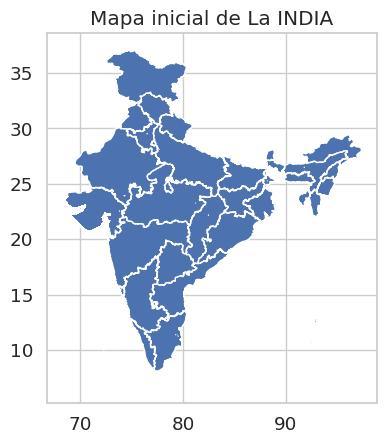

In [41]:
dfMAP.plot(missing_kwds={'color': 'lightgrey'})
plt.title("Mapa inicial de La INDIA")
plt.show()

- Se requiere superponer las etiquetas de los estados de la India en el mapa generado

In [42]:
#Se importa el ajuste para hacer posición de las etiquetas
from adjustText import adjust_text

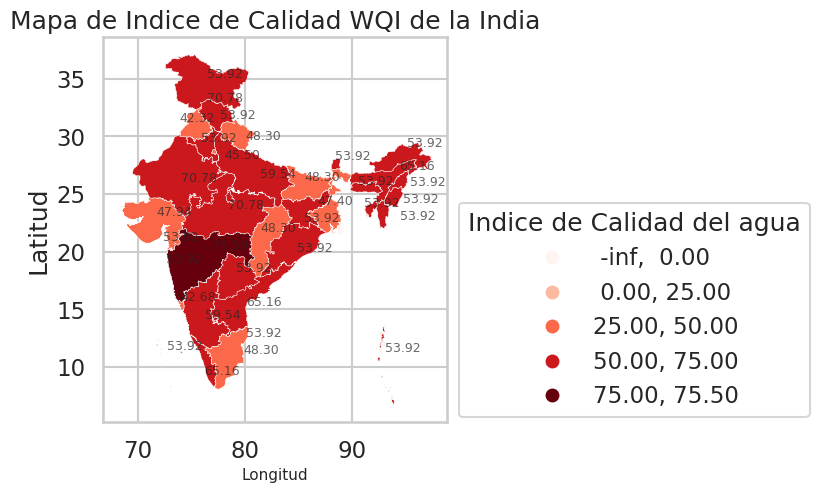

In [43]:
#Se verifica los valores NULOS; en caso de que existan se cambian por el promedio
#Se toma la ruta corta (la importación de valores nulos puede ser mejor tratada)
dfMAP ['WQI'] = dfMAP ['WQI'].fillna(dfMAP['WQI'].median())

#Configuración de estilos para impresión con Seaborn
sns.set_context("talk") #Puede cambiarse
sns.set_style("whitegrid") #Puede cambiarse a cualquiera

#Se ajusta el mapa
fig, ax= plt.subplots(figsize = (5,5))

#Dibujamos el mapa
dfMAP.plot(column='WQI', cmap='Reds', ax=ax, scheme='userdefined',
          classification_kwds={'bins': [0,25,50,75]},
          legend=True, linewidth = 0.3)

#Ajusta la leyenda
leg = ax.get_legend()
leg.set_title('Indice de Calidad del agua')
leg.set_bbox_to_anchor((1,0.6))

# Se agregan las etiquetas sin superposición (tener cuidado con el tamaño del Plot)
textos = []
for _, row in dfMAP.iterrows():
    if not np.isnan(row['WQI']):
        centroide = row.geometry.centroid
        texto = ax.annotate(f"{row['WQI']:.2f}",
            xy = (centroide.x, centroide.y), fontsize = 9, alpha = 0.7)
        textos.append(texto)

#Ajustar texto de etiquetas
adjust_text(textos, ax=ax, force_points=(0.2, 0.2))

# Carapinteria
ax.set_title("Mapa de Indice de Calidad WQI de la India")
ax.set_xlabel("Longitud", fontsize=11)
ax.set_ylabel("Latitud")

plt.show()

### **Histograma de WQI por Estado**

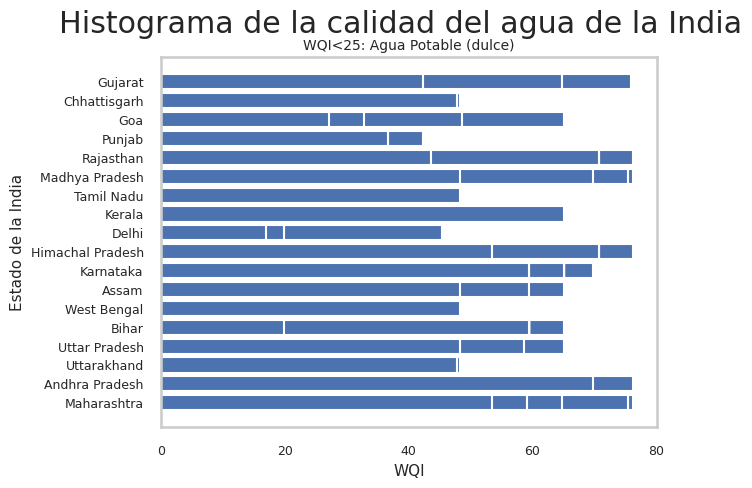

In [44]:
df06.createOrReplaceTempView("df06_sql")

#Se seleccionan los nombres de los estados
Estados = spark06.sql("Select STATE from df06_sql")
Estados = Estados.rdd.map(lambda row: row.STATE).collect()

#Seleccionamos los valores de WQI
wqi = spark06.sql("Select WQI from df06_sql")
wqi = wqi.rdd.map(lambda row: row.WQI).collect()

#Graficamos
plt.barh(Estados,wqi)
plt.suptitle("Histograma de la calidad del agua de la India")
plt.title("WQI<25: Agua Potable (dulce)", fontsize = 10)
plt.xlabel("WQI", fontsize =11 )
plt.ylabel("Estado de la India",  fontsize = 11)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)

plt.grid()
plt.show()

## **Aplicación de ML para predecir la calidad del agua en la India**

Para esta sección se propone la utilización y configuración de dos ajustes de parámetros para un modelo de Machine Learning basado en Keras. Una vez se apliquen las dos configuraciones de parámetros se realizará un análisis comparativo del comportamiento de los mismos para definir cuál funcionó más acorde al resultado esperado y qué cosas podrían mejorarse en futuras implementaciones

### **Creación del Modelo**

- Se requiere predecir el parámetro WQI
- Se crea un dataframe en pandas, un vector para manipular a través de numpy las columnas de calidad "Rangos de Calidad"
- Se importa Scikit-learn para separar los datos (Entrenamiento y Prueba)
- Se importa Keras Sequential Layers Dense
- Se inicializa el modelo, y se añaden las capas
- Se compila el modelo con el optimiador ADAM junto con la función de perdida de error cuadrático
- Se realiza el experimento sobre los datos de entrenamiento
- Se realiza la evaluación sobre los datos de prueba para la selección del modelo

In [45]:
# Se requiere predecir el WQI
# Se crea un dataframe en pandas, un vector para manipular a través de numpy las columnas de calidad "Rangos de Calidad"
dfcalidad = df06.select ( 'qrPH', 'qrDO', 'qrCOND', 'qrBOD', 'qrNN', 'qrFecal' )
dfPredecir = df06.select('WQI')

dfcalidad.show(5)
dfPredecir.show(5)

+----+----+------+-----+----+-------+
|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal|
+----+----+------+-----+----+-------+
| 100| 100|     0|    0| 100|    100|
| 100| 100|    40|    0| 100|     60|
| 100|  80|     0|    0| 100|     60|
| 100|  80|     0|    0| 100|     60|
| 100|  80|    40|    0| 100|     80|
+----+----+------+-----+----+-------+
only showing top 5 rows

+-----+
|  WQI|
+-----+
| 75.5|
|64.26|
|58.64|
|58.64|
|64.26|
+-----+
only showing top 5 rows



In [46]:
#Se crea un dataframe en pandas, un vector para manipular a través de numpy las columnas de calidad "Rangos de Calidad"
#Se importa Scikit-learn para separar los datos (Entrenamiento y Prueba)

from sklearn.model_selection import train_test_split

dataTrain, dataTest, predTrain, predTest = train_test_split(dfcalidad.toPandas(), dfPredecir.toPandas(), test_size=0.2, random_state=1)


In [47]:
print(f"Cantidad de datos totales: {df06.count(), len(df06.columns)}")
print(f"Cantidad de datos de Entrenamiento: {dataTrain.shape}")
print(f"Cantidad de datos de Prueba: {dataTest.shape}")
print(f"Cantidad de datos para predicción Entrenamiento: {predTrain.shape}")
print(f"Cantidad de datos para predicción Prueba: {predTest.shape}")

Cantidad de datos totales: (534, 24)
Cantidad de datos de Entrenamiento: (427, 6)
Cantidad de datos de Prueba: (107, 6)
Cantidad de datos para predicción Entrenamiento: (427, 1)
Cantidad de datos para predicción Prueba: (107, 1)


### **Primer ajuste de parámetros**

En este primer ajuste se utilizará una arquitectura profunda compuesta por tres capas densas de 350 neuronas cada una, todas con función de activación ReLU, y una capa de salida lineal para la predicción. Se empleó el optimizador Adam con una tasa de aprendizaje estándar (0.001), manteniendo los valores por defecto de beta_1 y beta_2. El entrenamiento se realizó durante 200 épocas con un tamaño de lote de 81 datos.
Esta propuesta de ajustes busca capturar relaciones complejas entre las característica, favoreciendo la capacidad de aprendizaje del modelo.

In [48]:
## Se importa la instancia de TensorFlow
import keras
from keras.models import Sequential
from keras.layers import Dense

2025-10-25 16:22:43.854532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 16:22:43.855002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 16:22:43.989084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 16:22:45.616097: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [49]:
#Se ajustan las variables: el ajuste es de forma estándar. Se requiere un estudio profundo
#sobre el ajuste de los parámetros, para que el modelo sea mucho más eficiente. El estudio a contiunuación es
#una guía para abordar modelos de Tensores en predicción de calidad del agua, como guía metodológica académica

epocas = 200
lote = 81
#Se inicializa el modelo con las capas
modelo01 = Sequential()
modelo01.add(Dense(350,input_dim=6,activation='relu'))
modelo01.add(Dense(350,activation='relu'))
modelo01.add(Dense(350,activation='relu'))
modelo01.add(Dense(1,activation='linear'))

/home/estudiante/miniconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-25 16:22:45.830640: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [50]:
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
modelo01.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse'])

In [51]:
modelo01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 350)            │         2,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           351 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,501 (970.71 KB)

 Trainable params: 248,501 (970.71 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
ejecutarK = modelo01.fit(dataTrain, predTrain, epochs=epocas, batch_size=lote)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1069.4822 - mse: 1069.4822
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 115.7576 - mse: 115.7576
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 31.7857 - mse: 31.7857 
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13.3964 - mse: 13.3964 
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.2558 - mse: 10.2558 
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5364 - mse: 7.5364  
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3205 - mse: 4.3205 
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1037 - mse: 2.1037
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2847 - mse: 1.2847 
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6889 - mse: 0.6889
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4058 - mse: 0.4058 
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2647 - mse: 0.2647 
Epoch 13/200
6/6 ━━━━━━━━━━━━━━

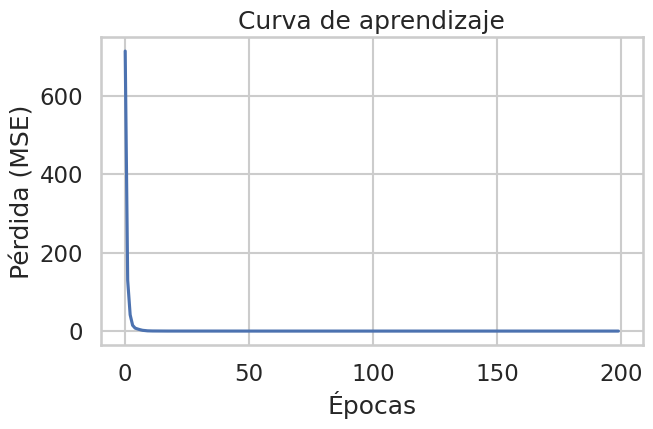

In [69]:
plt.figure(figsize=(7,4))
plt.plot(ejecutarK.history['loss'])
plt.title("Curva de aprendizaje")
plt.xlabel("Épocas")
plt.ylabel('Pérdida (MSE)')
plt.show()

En esta gráfica se puede observar que la pérdida (MSE) inicia en un valor bastante elevado, sin embargo, rápidamente se estabiliza, ya que a partir de desde el intervalo entre las épocas 10 y 20 el valor se observa un comportamiento constante, indicando que este primer ajuste de parámetros permite al modelo aprender de forma efectiva desde el inicio, alcanzando su punto óptimo de forma rápida. 

In [54]:
#Se requiere predecir sobre los datos del entrenamiento
predModelo01_Train = modelo01.predict(dataTrain)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


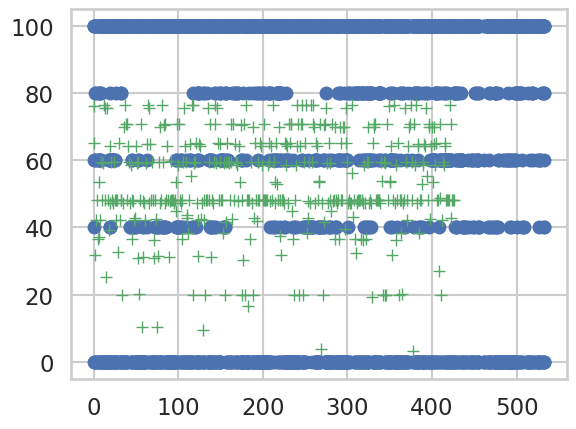

In [55]:
#Se grafica la predicción
plt.plot(dataTrain, 'bo', predModelo01_Train, 'g+')
plt.show()

### **Segundo ajuste de parámetros**

En este ajuste se introdujo un diseño más compacto con capas densas de 128, 64 y 32 neuronas respectivamente, usando también la función de activación ReLU. Se incorporó una capa Dropout del 30% para reducir el riesgo de sobreajuste y mejorar la capacidad de generalización del modelo. Además, la tasa de aprendizaje del optimizador Adam se redujo a 0.0005 para permitir un entrenamiento más suave y estable.
Este enfoque busca combinar una menor complejidad y regularización, buscando un equilibrio entre precisión y generalización.

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

modelo02 = Sequential([
    Dense(128, input_dim=dataTrain.shape[1], activation='relu'),
    Dropout(0.3),  # previene sobreajuste
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # salida
])


/home/estudiante/miniconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
opt = Adam(learning_rate=0.0005)  # más bajo que el original (0.001)
modelo02.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])

In [58]:
ejecutarK2 = modelo02.fit(dataTrain, predTrain, epochs=200, batch_size=16, verbose=1)

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1714.5361 - mse: 1714.5361   
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 217.7822 - mse: 217.7822 
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 124.4116 - mse: 124.4116 
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87.6810 - mse: 87.6810 
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86.3385 - mse: 86.3385
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67.3282 - mse: 67.3282 
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63.1495 - mse: 63.1495
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63.6864 - mse: 63.6864 
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.3539 - mse: 53.3539 
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43.3413 - mse: 43.3413
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.0776 - mse: 49.0776
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.6811 - mse: 41.6

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataTrain_scaled = scaler.fit_transform(dataTrain)

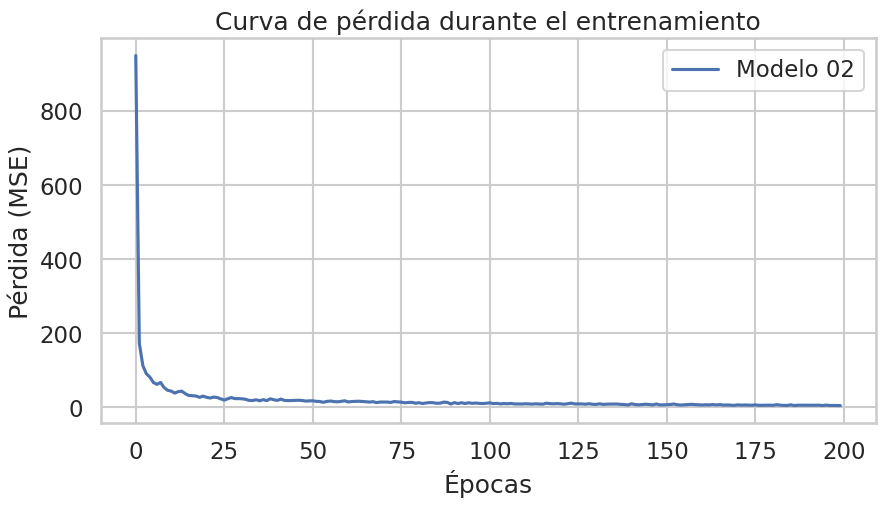

In [70]:
plt.figure(figsize=(10,5))
plt.plot(ejecutarK2.history['loss'], label='Modelo 02')
plt.title('Curva de pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.show()


En esta gráfica se puede observar que para este segundo ajuste de parámetros hay un comportamiento similar al que presenta el primer ajuste, siendo que la pérdida comienza en un valor muy elevado y disminuye rápidamente hasta encontrar un punto en el que se estabiliza cerca de la época 25. Sin embargo, también se observan pequeñas fluctuaciones a lo largo del entrenamiento, esto debido posiblemente al uso del Dropout en este ajuste, que es una técnica diseñada especialmente para evitar el sobreajuste desactivando algunas neuronas durante el proceso de aprendizaje.

## **Comparativa de ajustes de parámetros**

Para tener mayor claridad acerca de como los ajustes de ciertos parámetros en el diseño de los modelos y como estos impactan en las predicciones que realizan, a continuación se proponen algunos análisis comparativos entre el primer ajuste de parámetros y el segundo.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


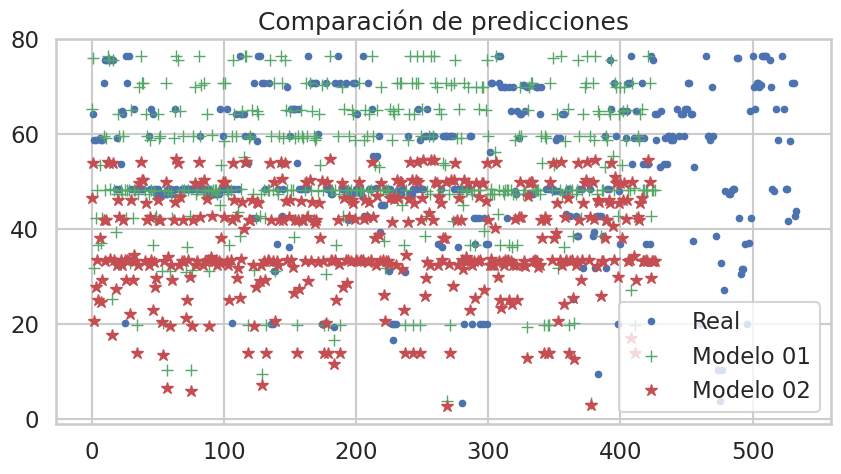

In [61]:
#Se genera una gráfica en la que se comparan los valores de predicción de cada uno de los modelos contra los valores reales y 
#se superponen para encontrar una mayor facilidad al realizar el análisis.

predModelo01 = modelo01.predict(dataTrain)
predModelo02 = modelo02.predict(dataTrain)

plt.figure(figsize=(10,5))
plt.plot(predTrain, 'b.', label='Real')
plt.plot(predModelo01, 'g+', label='Modelo 01')
plt.plot(predModelo02, 'r*', label='Modelo 02')
plt.title('Comparación de predicciones')
plt.legend()
plt.show()


### **Análisis gráfico de predicciones de los ajustes de parámetros**

En la gráfica comparativa se observa que el **Modelo 01 (en verde)** presenta una dispersión más concentrada y restringida dentro de un rango medio–alto de valores (alrededor de 50–70), lo que sugiere que **el modelo tiende a subestimar los valores bajos y sobreestimar los altos** de la calidad del agua. Esto indica que el modelo podría estar aprendiendo un patrón simplificado que no logra capturar adecuadamente las variaciones reales del conjunto de entrenamiento. Aun así, su comportamiento parece más conservador y menos ruidoso, lo que podría reflejar una **convergencia rápida pero poco profunda.**

Por su parte, el **Modelo 02 (en rojo)** muestra una distribución más amplia y con mayor variabilidad, extendiéndose hacia valores más bajos e intermedios. Esto evidencia que **el modelo aprende un rango de comportamiento más diverso, aunque con cierta inestabilidad o dispersión en las predicciones.** Es posible que los ajustes introducidos (mayor profundidad, regularización y tasa de aprendizaje más baja) le permitan explorar mejor los datos, pero todavía sin alcanzar una correspondencia cercana con los valores reales (en azul). 

En conjunto, el Modelo 02 exhibe un aprendizaje más flexible pero menos preciso, mientras que el Modelo 01 es más estable aunque limitado; la combinación ideal estaría en un punto intermedio entre ambos comportamientos.

### **Métricas comparativas**

Con el fin de analizar y comparar el rendimiento de los modelos desarrollados, se emplearon diversas métricas que permiten cuantificar su capacidad para aproximar los valores reales de calidad del agua. Estas métricas evalúan el error entre los valores predichos y los observados, así como la capacidad del modelo para explicar la variabilidad del conjunto de datos. Las métricas utilizadas son las siguientes:

- **Mean Squared Error (MSE):** Mide el promedio de los errores elevados al cuadrado. Penaliza fuertemente los errores grandes y permite identificar qué tan lejos están, en promedio, las predicciones del modelo respecto a los valores reales. Valores más bajos indican un mejor rendimiento.

- **Mean Absolute Error (MAE):** Representa el promedio de las diferencias absolutas entre predicciones y valores reales. A diferencia del MSE, no amplifica errores grandes, por lo que ofrece una visión más directa y menos sensible a valores atípicos.

- **Root Mean Squared Error (RMSE):** Es la raíz cuadrada del MSE. Al expresarse en las mismas unidades que la variable objetivo, resulta más interpretable para evaluar la magnitud promedio del error de predicción.

- **Coeficiente de Determinación (R²):** Indica qué proporción de la variabilidad de los datos es explicada por el modelo. Un valor cercano a 1 sugiere un ajuste casi perfecto, mientras que valores cercanos a 0 indican escasa capacidad predictiva. Valores negativos revelan que el modelo rinde peor que una predicción promedio básica.

A partir del cálculo de estas métricas para cada modelo, es posible realizar una comparación fundamentada que permita determinar cuál presenta un mejor desempeño y qué ajustes afectan positiva o negativamente su capacidad predictiva.

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predicciones de los modelos
pred1 = modelo01.predict(dataTrain)
pred2 = modelo02.predict(dataTrain)

# Métricas Modelo 01
mse1 = mean_squared_error(predTrain, pred1)
mae1 = mean_absolute_error(predTrain, pred1)
rmse1 = np.sqrt(mse1)
r2_1 = r2_score(predTrain, pred1)

# Métricas Modelo 02
mse2 = mean_squared_error(predTrain, pred2)
mae2 = mean_absolute_error(predTrain, pred2)
rmse2 = np.sqrt(mse2)
r2_2 = r2_score(predTrain, pred2)

print("----- Modelo 01 -----")
print(f"MSE : {mse1:.4f}")
print(f"MAE : {mae1:.4f}")
print(f"RMSE: {rmse1:.4f}")
print(f"R²  : {r2_1:.4f}")

print("\n----- Modelo 02 -----")
print(f"MSE : {mse2:.4f}")
print(f"MAE : {mae2:.4f}")
print(f"RMSE: {rmse2:.4f}")
print(f"R²  : {r2_2:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
----- Modelo 01 -----
MSE : 0.0003
MAE : 0.0152
RMSE: 0.0185
R²  : 1.0000

----- Modelo 02 -----
MSE : 268.3918
MAE : 15.9032
RMSE: 16.3827
R²  : -0.2447


Al comparar las métricas obtenidas para ambos modelos, se evidencia una diferencia significativa en su capacidad predictiva. **El Modelo 01** presenta valores extremadamente bajos de error: un MSE de 0.0003, MAE de 0.0152 y RMSE de 0.0185, lo que indica que sus **predicciones son prácticamente idénticas a los valores reales.** Además, el coeficiente R² = 1.0000 demuestra que **este modelo es capaz de explicar un porcentaje considerablemente alto de la variabilidad de los datos**, señalando un ajuste muy bueno. Sin embargo, valores tan altos de desempeño también pueden sugerir un posible sobreajuste, por lo que es importante evaluar su comportamiento con datos nunca antes vistos (validación externa).

Por otro lado, **el Modelo 02** muestra un rendimiento considerablemente inferior. Sus errores son mucho mayores (MSE = 268.39, MAE = 15.90 y RMSE = 16.38), lo que refleja **predicciones más alejadas de los valores reales.** Además, el coeficiente R² = -0.2447 indica que el modelo no solo **no logra explicar la variabilidad de los datos, sino que desempeña peor que una predicción promedio básica**, lo que evidencia que su estructura y/o parámetros no resultan adecuados para este problema. 

En conjunto, estos resultados muestran que el Modelo 01 es ampliamente superior en términos de precisión y ajuste, mientras que el Modelo 02 requiere una reconfiguración o selección de características más adecuada para mejorar su desempeño.

### **Error Residual**

El análisis de los errores residuales permite evaluar con mayor detalle el comportamiento de un modelo de predicción. El residual se define como la diferencia entre el valor real y el valor estimado por el modelo. Este análisis es importante porque no solo indica qué tan lejos se encuentran las predicciones respecto a los datos verdaderos, sino que también permite identificar patrones de error que puedan sugerir problemas como sobreajuste, subajuste o una mala especificación del modelo.

En esta subsección el propósito es generar una visualización gráfica de esta métrica para ejemplificar mejor las diferencias entre los dos ajustes de parámetros del modelo.

In [65]:
import numpy as np

# Convertir valores reales a arreglo 1D
y_train = np.array(predTrain).reshape(-1)

# Convertir las predicciones a arreglo 1D
pred1_flat = pred1.reshape(-1)
pred2_flat = pred2.reshape(-1)

# Calcular residuales
residuals1 = y_train - pred1_flat
residuals2 = y_train - pred2_flat


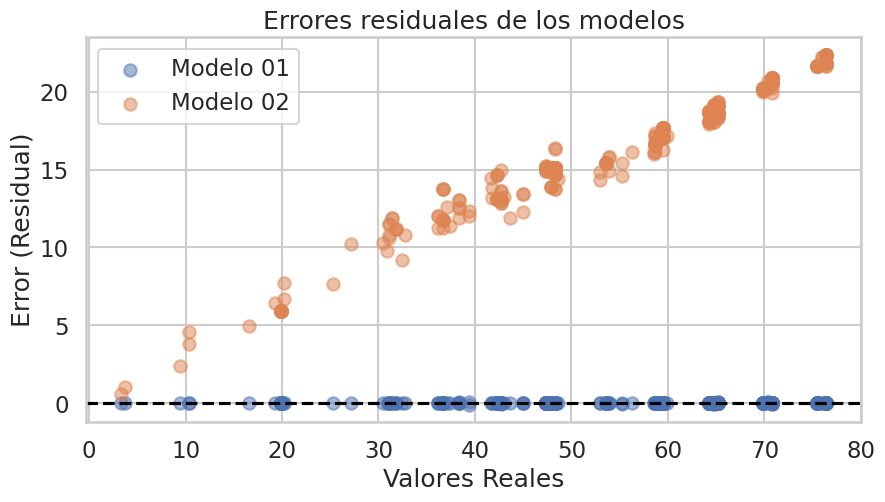

In [66]:
#Se genera la visualización comparativa del error residual de los dos modelos
plt.figure(figsize=(10,5))
plt.scatter(predTrain, residuals1, alpha=0.5, label='Modelo 01')
plt.scatter(predTrain, residuals2, alpha=0.5, label='Modelo 02')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Valores Reales")
plt.ylabel("Error (Residual)")
plt.title("Errores residuales de los modelos")
plt.legend()
plt.show()


En el gráfico se observa la comparación de los errores residuales de ambos modelos respecto a los valores reales. El Modelo 01 (puntos azules) presenta residuales prácticamente iguales a cero a lo largo de todo el rango de valores reales. Esto indica que el modelo está prediciendo los valores con una precisión casi exacta. La ausencia de dispersión y de tendencia en los residuales refleja un ajuste extremadamente bueno, sin señales evidentes de sobreajuste ni de sesgos sistemáticos en la predicción.

Por otro lado, el Modelo 02 (puntos naranjas) muestra residuales claramente mayores y con una tendencia creciente. Conforme aumentan los valores reales, el error residual también incrementa, lo que indica que el modelo está subestimando los valores altos de la variable objetivo. Esta tendencia revela que el Modelo 02 no está capturando adecuadamente la relación entre las variables y presenta una menor capacidad de generalización. La dispersión amplia y la magnitud elevada de los residuales evidencian que el desempeño del Modelo 02 es significativamente inferior en comparación con el Modelo 01.

En resumen, el comportamiento del error residual confirma que el Modelo 01 ofrece un ajuste notablemente superior, mientras que el Modelo 02 presenta errores sistemáticos y mayor variabilidad en sus predicciones.

# **Conclusiones**

1. La calidad del agua presenta variabilidad significativa entre regiones, lo que sugiere que las condiciones ambientales, el acceso a infraestructura y el manejo local del recurso hídrico influyen directamente en los niveles de contaminación. Algunas zonas mostraron valores dentro de los rangos aceptables, mientras que otras excedieron los límites recomendados para consumo humano.

2. Los parámetros físico-químicos analizados mostraron correlaciones importantes entre sí, especialmente entre aquellos relacionados con la salinidad y la presencia de sólidos disueltos. Esto indica que ciertas fuentes de contaminación tienen un origen común, posiblemente asociado a vertimientos domésticos, agrícolas o industriales.

3. Se evidenció que en varias muestras los valores de algunas dimensiones no superan los límites críticos, lo cual indica que el agua podría ser apta para consumo tras un tratamiento mínimo. Sin embargo, en áreas más afectadas, la calidad disminuye notablemente, lo que implica la necesidad de procesos de potabilización más robustos.

4. Las visualizaciones permitieron identificar patrones espaciales de riesgo hídrico, revelando zonas donde se requiere priorizar acciones de monitoreo, control y saneamiento. Esto es especialmente relevante para comunidades rurales donde la dependencia de fuentes naturales es mayor.

5. El estudio resalta la importancia de implementar políticas públicas de gestión del agua que incluyan monitoreo continuo, educación ambiental y mejora de infraestructuras de tratamiento, aunque no sea posible determinar esta guía como un estudio teórico suficiente para un análisis detallado de la calidad de agua en la India.